In [13]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage.filters import frangi
from skimage.color import rgb2gray
from skimage.morphology import closing, square
from skimage.morphology import remove_small_objects
from skimage.morphology import skeletonize
from skimage.measure import moments_central, moments_hu
import skimage.exposure as exp
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.metrics import BinaryIoU
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown
from sklearn.metrics import confusion_matrix


In [ ]:

# Ścieżka do folderu z obrazami
image_dir = 'images'

# Lista dostępnych obrazów .ppm (bez masek .ah)
image_files = [f for f in os.listdir(image_dir) if f.endswith('.ppm') and '.ah' not in f]
image_files.sort()

@interact(filename=Dropdown(options=image_files, description='Obraz:'))
def run_pipeline(filename):
    image_path = os.path.join(image_dir, filename)
    ah_path = image_path.replace('.ppm', '.ah.ppm')

    # 1. Wczytaj kolorowy obraz (BGR)
    img = cv2.imread(image_path)
    ideal_result = cv2.imread(ah_path, 0) > 0

    img_blur = cv2.GaussianBlur(img, (5, 5), 0)
    gray_mask = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
    _, fov_mask = cv2.threshold(gray_mask, 45, 255, cv2.THRESH_BINARY)
    fov_mask = fov_mask > 0

    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YCrCb2BGR)
    img_rgb = cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB)
    gray = rgb2gray(img_rgb)

    # 7. Filtr Frangiego
    frangi_result = frangi(gray)
    frangi_result[~fov_mask] = 0
    thr = np.percentile(frangi_result[fov_mask], 93)
    binary = (frangi_result > thr) & fov_mask

    # 9–11: obróbka morfologiczna
    binary_closed = closing(binary, square(3))
    binary_cleaned = remove_small_objects(binary_closed, min_size=25)
    binary_skeleton = skeletonize(binary_cleaned)

    # Wyświetlanie wyników
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Oryginalny")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Po equalizacji histogramu")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Maska FOV")
    plt.imshow(fov_mask, cmap='gray')
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Po filtrze frangiego")
    plt.imshow(frangi_result, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Po domknięciu naczyń")
    plt.imshow(binary_closed, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Po usunięciu szumów")
    plt.imshow(binary_cleaned, cmap='gray')
    plt.axis('off')
    plt.show()

    # Obraz referencyjny
    plt.figure(figsize=(5, 5))
    plt.title("Obraz referencyjny (idealny)")
    plt.imshow(ideal_result, cmap='gray')
    plt.axis('off')
    plt.show()

    # Oblicz metryki
    TP = np.logical_and(binary_cleaned == 1, ideal_result == 1).sum()
    TN = np.logical_and(binary_cleaned == 0, ideal_result == 0).sum()
    FP = np.logical_and(binary_cleaned == 1, ideal_result == 0).sum()
    FN = np.logical_and(binary_cleaned == 0, ideal_result == 1).sum()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    balanced_accuracy = (sensitivity + specificity) / 2

    cm = confusion_matrix(ideal_result.flatten(), binary_cleaned.flatten())
    print("Confusion matrix:\n", cm)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")




interactive(children=(Dropdown(description='Obraz:', options=('im0001.ppm', 'im00010.ppm', 'im00011.ppm', 'im0…

In [19]:
# Parametry
window_size = 10
step = 5
image_dir = "images"

# Wczytaj obrazy i maski
images = []
masks = []
for i in range(1, 21):
    images.append(cv2.imread(f"{image_dir}/im000{i}.ppm"))
    masks.append(cv2.imread(f"{image_dir}/im000{i}.ah.ppm", cv2.IMREAD_GRAYSCALE))

# Ekstrakcja cech
features, labels, rows = [], [], []
for idx in range(len(images)):
    img = images[idx]
    mask = masks[idx]

    img_blur = cv2.GaussianBlur(img, (5, 5), 0)
    b, g, r = cv2.split(img_blur)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_eq = cv2.merge((clahe.apply(b), clahe.apply(g), clahe.apply(r)))
    img_rgb = cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB)
    gray = rgb2gray(img_rgb)
    
    h, w = gray.shape
    for y in range(0, h - window_size + 1, step):
        for x in range(0, w - window_size + 1, step):
            patch = gray[y:y+window_size, x:x+window_size]
            var = np.var(patch)
            hu = moments_hu(moments_central(patch))
            label = mask[y + window_size // 2, x + window_size // 2]
            row = {"var": var, **{f"hu_{i}": hu[i] for i in range(7)}, "label": label}
            rows.append(row)
            features.append(np.concatenate([[var], hu]))
            labels.append(label)

# Przygotowanie danych
data = pd.DataFrame(rows)
X = data.iloc[:, :-1]
y_train = data.iloc[:, -1]

# Skalowanie i balansowanie
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(scaled_data, y_train)

# Trening SVM
svm_model = svm.SVC(kernel='linear', C=1, class_weight='balanced')
svm_model.fit(X_train, y_train)

# Trening k-NN
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=6)
knn_model.fit(X_train, y_train)

print("Modele SVM i k-NN wytrenowane.")


Modele SVM i k-NN wytrenowane.


In [21]:

# Lista dostępnych obrazów
image_files = [f for f in os.listdir(image_dir) if f.endswith('.ppm') and '.ah' not in f]
image_files.sort()

selected_filename = None
ideal_img = None 

# Obsługa wyboru
def on_image_selected(change):
    global selected_filename, ideal_img
    selected_filename = change['new']
    ideal_filename = selected_filename.replace('.ppm', '.ah.ppm')

    # Wczytanie i konwersja do wartości binarnych (0 i 1) jako uint8
    img = cv2.imread(f"{image_dir}/{ideal_filename}", cv2.IMREAD_GRAYSCALE)
    ideal_img = (img > 127).astype(np.uint8)

    print(f"Wybrano obraz testowy: {selected_filename}")

# Dropdown
dropdown = Dropdown(options=image_files, description="Obraz:")
dropdown.observe(on_image_selected, names='value')
display(dropdown)


Dropdown(description='Obraz:', options=('im0001.ppm', 'im00010.ppm', 'im00011.ppm', 'im00012.ppm', 'im00013.pp…

c:\Users\pawma\Documents\Informatyka 6 semestr\Informatyka w medycynie\DnoOka\Informatyka-w-Medycynie\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


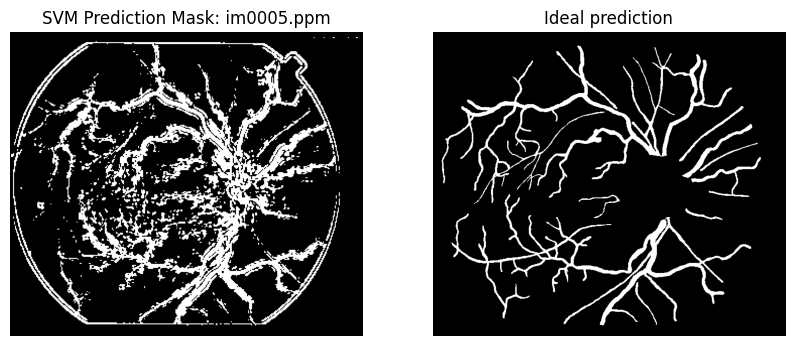

Confusion matrix:
[[325337  59906]
 [ 18851  19406]]

Accuracy: 0.8140
Sensitivity (Recall): 0.5073
Specificity: 0.8445
Balanced Accuracy: 0.6759
IoU (Intersection over Union): 0.1977
Dice Coefficient: 0.3301


In [ ]:
# Wczytanie obrazu testowego
test_img = cv2.imread(f"{image_dir}/{selected_filename}")
gray = rgb2gray(cv2.cvtColor(
    cv2.merge([clahe.apply(c) for c in cv2.split(cv2.GaussianBlur(test_img, (5, 5), 0))]),
    cv2.COLOR_BGR2RGB
))

h, w = gray.shape
step_test = 2
positions, test_features, test_rows = [], [], []

for y in range(0, h - window_size + 1, step_test):
    for x in range(0, w - window_size + 1, step_test):
        patch = gray[y:y+window_size, x:x+window_size]
        var = np.var(patch)
        hu = moments_hu(moments_central(patch))
        row = {"var": var, **{f"hu_{i}": hu[i] for i in range(7)}}
        test_rows.append(row)
        test_features.append(np.concatenate([[var], hu]))
        positions.append((y, x))

test_data = pd.DataFrame(test_rows)
X_test_scaled = scaler.transform(np.array(test_data))
y_final = svm_model.predict(X_test_scaled)

# Rekonstrukcja maski
grid_h = (h - window_size) // step_test + 1
grid_w = (w - window_size) // step_test + 1
output_mask = np.zeros_like(gray, dtype=np.uint8)
for idx, (y, x) in enumerate(positions):
    output_mask[y:y+window_size, x:x+window_size] = y_final[idx]

# Wyświetlenie
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(output_mask, cmap='gray')
plt.title(f"SVM Prediction Mask: {selected_filename}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ideal_img, cmap='gray')
plt.title(f"Ideal prediction")
plt.axis('off')
plt.show()

pred_binary = (output_mask > 0).astype(np.uint8)
ideal_binary = (ideal_img > 0).astype(np.uint8)

# macierz pomyłek
cm = confusion_matrix(ideal_binary.flatten(), pred_binary.flatten())
print("Confusion matrix:")
print(cm)

TP = np.logical_and(pred_binary == 1, ideal_binary == 1).sum()
TN = np.logical_and(pred_binary == 0, ideal_binary == 0).sum()
FP = np.logical_and(pred_binary == 1, ideal_binary == 0).sum()
FN = np.logical_and(pred_binary == 0, ideal_binary == 1).sum()

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
balanced_accuracy = (sensitivity + specificity) / 2

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")





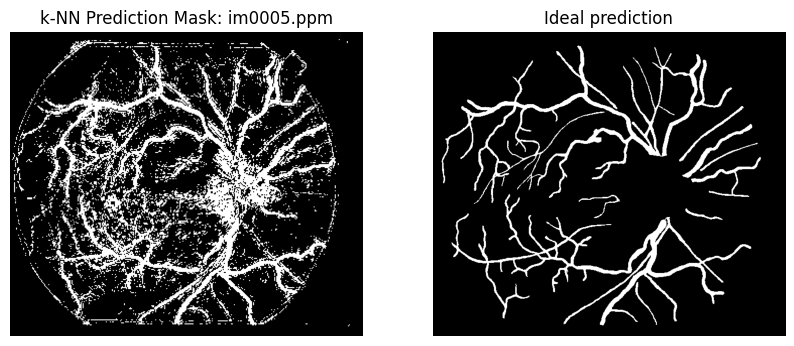

Confusion matrix:
[[321277  63966]
 [ 18143  20114]]

Accuracy: 0.8061
Sensitivity (Recall): 0.5258
Specificity: 0.8340
Balanced Accuracy: 0.6799


In [28]:
# Predykcja i rekonstrukcja maski k-NN
y_final_knn = knn_model.predict(X_test_scaled)

output_mask_knn = np.zeros_like(gray, dtype=np.uint8)
for idx, (y, x) in enumerate(positions):
    output_mask_knn[y:y+window_size, x:x+window_size] = y_final_knn[idx]

# Wyświetlenie
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(output_mask_knn, cmap='gray')
plt.title(f"k-NN Prediction Mask: {selected_filename}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ideal_img, cmap='gray')
plt.title(f"Ideal prediction")
plt.axis('off')

plt.show()

pred_binary = (output_mask_knn > 0).astype(np.uint8)
ideal_binary = (ideal_img > 0).astype(np.uint8)

# macierz pomyłek
cm = confusion_matrix(ideal_binary.flatten(), pred_binary.flatten())
print("Confusion matrix:")
print(cm)

TP = np.logical_and(pred_binary == 1, ideal_binary == 1).sum()
TN = np.logical_and(pred_binary == 0, ideal_binary == 0).sum()
FP = np.logical_and(pred_binary == 1, ideal_binary == 0).sum()
FN = np.logical_and(pred_binary == 0, ideal_binary == 1).sum()

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
balanced_accuracy = (sensitivity + specificity) / 2

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")



In [5]:

images = []
masks = []

for i in range(1, 21):
    images.append(cv2.imread(f"images/im000{i}.ppm"))
    masks.append(cv2.imread(f"images/im000{i}.ah.ppm", cv2.IMREAD_GRAYSCALE))

# Parametry patchy
window_size = 15
step = 2
patches = []
labels = []
positions = []

for idx in range(len(images)):
    image = images[idx]
    mask = masks[idx]

    # Rozmycie i CLAHE
    img_blur = cv2.GaussianBlur(image, (5, 5), 0)
    b, g, r = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    b_clahe = clahe.apply(b)
    g_clahe = clahe.apply(g)
    r_clahe = clahe.apply(r)
    img_eq = cv2.merge((b_clahe, g_clahe, r_clahe))

    # Na szaro
    img_rgb = cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB)
    gray = rgb2gray(img_eq)
    gray = (gray * 255).astype('uint8')  # konwersja do 0–255, jak maska

    h, w = gray.shape

    for y in range(0, h - window_size + 1, step):
        for x in range(0, w - window_size + 1, step):
            center_y = y + window_size // 2
            center_x = x + window_size // 2

            # Sprawdź, czy środek patcha mieści się w obrazie i masce
            if center_y >= h or center_x >= w:
                continue

            patch = gray[y:y+window_size, x:x+window_size].astype('float32') / 255.0
            patch = patch[..., np.newaxis]

            label = mask[center_y, center_x]
            label = 1 if label > 0 else 0

            patches.append(patch)
            labels.append(label)
            positions.append((y, x))  # <-- ZAMIENIAMY na oryginalną pozycję patcha, NIE center


X = np.array(patches)   # (N, 10, 10, 1)
y = np.array(labels)    # (N,)
assert len(positions) == len(X) == len(y)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(15, 15, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=2048)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 15, 15, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,649 (858.00 KB)

 Trainable params: 219,649 (858.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 130s 159ms/step - accuracy: 0.9319 - loss: 0.2135 - precision: 0.6085 - recall: 0.1942 - val_accuracy: 0.9564 - val_loss: 0.1159 - val_precision: 0.8103 - val_recall: 0.5819
Epoch 2/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 123s 155ms/step - accuracy: 0.9569 - loss: 0.1148 - precision: 0.7962 - recall: 0.6153 - val_accuracy: 0.9602 - val_loss: 0.1034 - val_precision: 0.7881 - val_recall: 0.6747
Epoch 3/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 122s 154ms/step - accuracy: 0.9598 - loss: 0.1050 - precision: 0.8057 - recall: 0.6532 - val_accuracy: 0.9617 - val_loss: 0.0994 - val_precision: 0.8488 - val_recall: 0.6239
Epoch 4/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 122s 153ms/step - accuracy: 0.9619 - loss: 0.0994 - precision: 0.8160 - recall: 0.6703 - val_accuracy: 0.9633 - val_loss: 0.0947 - val_precision: 0.7914 - val_recall: 0.7241
Epoch 5/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 127s 160ms/step - accuracy: 0.9635 - loss: 0.0952 - precision: 0.8216 - recall: 0.6884 - val_accuracy: 0

In [ ]:

image_options = [f"im{i:04d}.ppm" for i in range(1, 21)]
selected_index = None

# Obsługa wyboru
def on_image_selected(change):
    global selected_index
    selected_index = image_options.index(change['new'])
    print(f"✅ Wybrano obraz: {change['new']} (index: {selected_index})")

dropdown = Dropdown(options=image_options, description="Obraz:")
dropdown.observe(on_image_selected, names='value')
display(dropdown)


Dropdown(description='Obraz:', options=('im0001.ppm', 'im0002.ppm', 'im0003.ppm', 'im0004.ppm', 'im0005.ppm', …

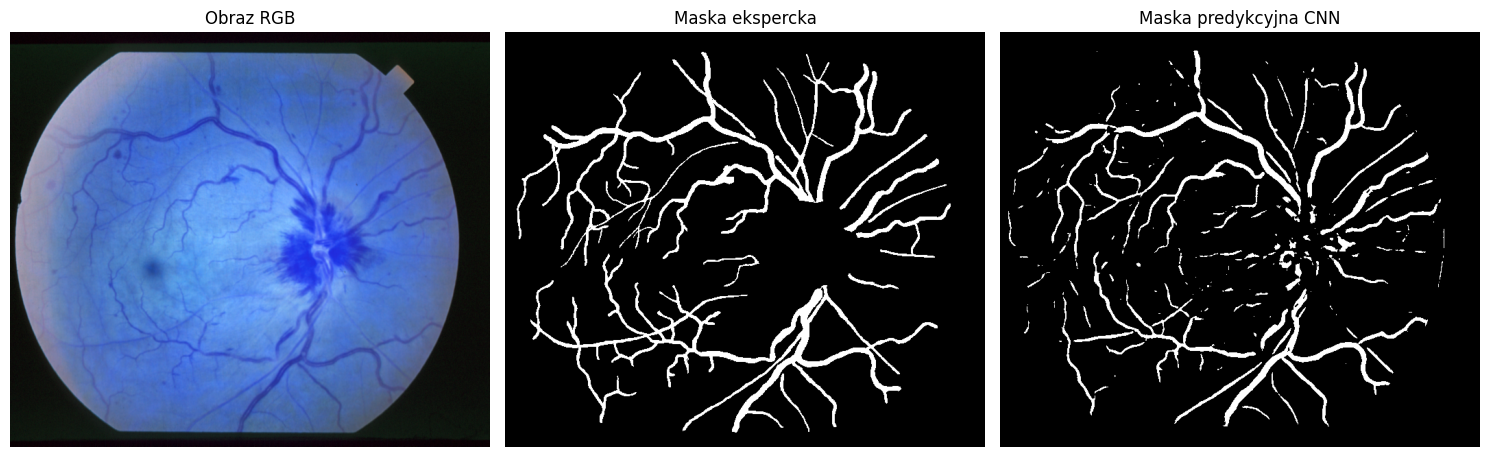

Confusion matrix:
 [[360604  24639]
 [ 32533   5724]]
Accuracy: 0.8650
Sensitivity (Recall): 0.1496
Specificity: 0.9360
Balanced Accuracy: 0.5428
IoU (Intersection over Union): 0.0910
Dice Coefficient: 0.1668


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

if selected_index is None:
    print("Najpierw wybierz obraz z dropdowna.")
else:
    window_size = 15
    step = 1
    image = images[selected_index]
    mask = (masks[selected_index] > 127).astype(np.uint8)

    # Rozmycie i CLAHE
    img_blur = cv2.GaussianBlur(image, (5, 5), 0)
    b, g, r = cv2.split(img_blur)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    b_clahe = clahe.apply(b)
    g_clahe = clahe.apply(g)
    r_clahe = clahe.apply(r)
    img_eq = cv2.merge((b_clahe, g_clahe, r_clahe))

    # Konwersja do szarości
    gray = rgb2gray(cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB))
    gray = (gray * 255).astype('uint8')

    # Patchowanie
    h, w = gray.shape
    patches_test, positions_test = [], []

    for y in range(0, h - window_size + 1, step):
        for x in range(0, w - window_size + 1, step):
            center_y = y + window_size // 2
            center_x = x + window_size // 2
            if center_y >= h or center_x >= w:
                continue

            patch = gray[y:y+window_size, x:x+window_size].astype('float32') / 255.0
            patch = patch[..., np.newaxis]
            patches_test.append(patch)
            positions_test.append((y, x))

    X_test_single = np.array(patches_test)

    # Predykcja
    y_pred_test = (model.predict(X_test_single, verbose=0) > 0.5).astype(np.uint8).flatten()

    # Rekonstrukcja maski
    output_mask_pred = np.zeros_like(gray, dtype=np.uint8)
    for idx, (y, x) in enumerate(positions_test):
        output_mask_pred[y:y+window_size, x:x+window_size] = y_pred_test[idx]

    # Wyświetlenie wyników
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Obraz RGB")
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Maska ekspercka")
    axes[1].axis('off')

    axes[2].imshow(output_mask_pred, cmap='gray')
    axes[2].set_title("Maska predykcyjna CNN")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Oblicz metryki
    TP = np.logical_and(output_mask_pred == 1, mask == 1).sum()
    TN = np.logical_and(output_mask_pred == 0, mask == 0).sum()
    FP = np.logical_and(output_mask_pred == 1, mask == 0).sum()
    FN = np.logical_and(output_mask_pred == 0, mask == 1).sum()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    balanced_accuracy = (sensitivity + specificity) / 2
    cm = confusion_matrix(mask.flatten(), output_mask_pred.flatten())

    print("Confusion matrix:\n", cm)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

    
